In [1]:
import os
import pickle
from concurrent.futures import ThreadPoolExecutor, as_completed
import cProfile
import time
from glob import glob
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import RidgeCV
from isc_standalone import p_from_null
from ISC_Helper import get_rois, _compute_phaseshift_sliding_isc, load_roi_data
%matplotlib inline

/opt/anaconda3/envs/isc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
task = 'onesmallstep'
roi_selected = ['visualcortex', 'auditory', 'vmPFC', 'ACC', 'PCC', 'insula', 'amygdala', 'NA']
# roi_selected = ['PCC', 'ACC']
emotions = ['P', 'N', 'M', 'X', 'Cry']  # Positive, Negative, Mixed, Neutral
avg_over_roi = True
spatial = False
pairwise = False
random_state = None
window_size = 30
step_size = 5
if task == 'toystory':
    n_trs = 274 # 300
    n_shifts = 10000
elif task == 'onesmallstep':
    n_trs = 454  # 484 
    n_shifts = 10000
else:
    raise Exception('task not defined')
n_windows = int((n_trs - window_size) / step_size) + 1

smooth = 'smooth'
avg_over_roi_name = "avg" if avg_over_roi else "voxelwise"
spatial_name = "spatial" if spatial else "temporal"
pairwise_name = "pairwise" if pairwise else "group"

# -------------------------------
# File paths
# -------------------------------
amb_aff_path = '/Volumes/BCI/Ambivalent_Affect'
# amb_aff_path = '/Volumes/BCI-1/Ambivalent_Affect'
if task == 'toystory':
    data_dir_func = f'{amb_aff_path}/fMRI_Study/ISC_Data/ToyStoryNuisanceRegressed'
elif task == 'onesmallstep':
    data_dir_func = f'{amb_aff_path}/fMRI_Study/ISC_Data_cut/NuisanceRegressed'
else:
    raise ValueError('Invalid task')
func_fns = glob(join(data_dir_func, 'P?.nii.gz')) + glob(join(data_dir_func, 'N?.nii.gz')) + \
           glob(join(data_dir_func, 'VR?.nii.gz')) + glob(join(data_dir_func, 'P??.nii.gz')) + \
           glob(join(data_dir_func, 'N??.nii.gz')) + glob(join(data_dir_func, 'VR??.nii.gz'))

if task == 'toystory':
    # remove VR7 and 8 temporarily for testing because they are 295 not 300 TRs
    func_fns = [fn for fn in func_fns if 'VR7' not in fn and 'VR8' not in fn]
    label_dir = f'{amb_aff_path}/fMRI_Study/VideoLabelling/Toy_Story_Labelled'
elif task == 'onesmallstep':
    label_dir = f'{amb_aff_path}/fMRI_Study/VideoLabelling/OSS_Labelled'

subj_ids = [str(subj).split('/')[-1].split('.')[0] for subj in func_fns]  # assume BIDS format
subj_ids.sort()

roi_mask_path = f'{amb_aff_path}/rois'
all_roi_fpaths = glob(os.path.join(roi_mask_path, '*.nii*'))
all_roi_masker = get_rois(all_roi_fpaths)
data_path = f'{amb_aff_path}/RishabISC/ISC/data/{task}'
figure_path = f'{amb_aff_path}/RishabISC/ISC/figures/{task}'
# rating_path = f'/Volumes/BCI/Ambivalent_Affect/fMRI_Study/VideoLabelling/coded_df_{task}.nc'
isc_path = f"{data_path}/isc_sliding_{pairwise_name}_n{len(subj_ids)}_{avg_over_roi_name}_roi{len(roi_selected)}_" \
           f"window{window_size}_step{step_size}.pkl"
sliding_perm_path = f"{data_path}/sliding_isc/permutations/phaseshift_size{window_size}_step{step_size}"


In [3]:
# if task == 'onesmallstep':
# roi_selected = roi_selected[1:]

save_path = f"{sliding_perm_path}_{n_shifts}perms_{len(roi_selected)}rois_x"
with open(save_path, 'rb') as f:
    x = pickle.load(f)
    print('permutations loaded from file\n', save_path)

assert list(x.keys()) == roi_selected

permutations loaded from file
 /Volumes/BCI/Ambivalent_Affect/RishabISC/ISC/data/onesmallstep/sliding_isc/permutations/phaseshift_size30_step5_10000perms_8rois_x


In [4]:
x[roi_selected[0]][0].shape

(85, 1)

In [5]:
label_dir = '/Users/ri4541/Desktop/USC/VideoLabelling'
coded_states = np.load(f'{label_dir}/coded_states_{task}.npy')
print('shape before trimming:', coded_states.shape)
if task == 'onesmallstep':
    coded_states = coded_states[:, :-30]
elif task == 'toystory':
    coded_states = coded_states[:, :-26]    
    
print('shape after trimming:', coded_states.shape)


shape before trimming: (28, 484, 5)
shape after trimming: (28, 454, 5)


In [6]:
timepoint_variance = np.var(coded_states[:, :n_trs, :], axis=0)  # shape=(n_trs, n_emotions)

# Initialize sliding window output
slide_behav = np.zeros((n_windows, timepoint_variance.shape[1]))

# Calculate mean variance within each sliding window
for i in range(n_windows):
    start_idx = i * step_size
    end_idx = start_idx + window_size
    slide_behav[i] = np.mean(timepoint_variance[start_idx:end_idx], axis=0)

In [7]:
print('shape before removing:', slide_behav.shape)  # 8 rois, shape=(n_windows, n_emotions)
# remove crying and neutral to just focus on pos, neg, mix, for 8 rois
slide_behav = slide_behav[:, :3]
# slide_behav = np.delete(slide_behav, 3, axis=1)  # remove neutral
emotions = ['P', 'N', 'M', 'X', 'Cry']
emotions = emotions[:3]
print('shape after removing:', slide_behav.shape)

shape before removing: (85, 5)
shape after removing: (85, 3)


In [8]:
# test = np.zeros_like(slide_behav)
# print(test.shape)
# test = np.delete(test, 3, axis=1)
# print(test.shape)

In [9]:
# trim fmri data to match slide_behav
# x is a dict with keys as roi names and values as lists of observed, p, distribution
# trim the -2th dimension of all lists
# from copy import deepcopy
# tmp = deepcopy(x)
# for roi_name, roi_data in x.items():
#     for i in range(len(roi_data)):
#         if i != 2:
#             x[roi_name][i] = roi_data[i][:-6]
#         else:
#             x[roi_name][i] = roi_data[i][:, :-6]

In [10]:
print(x.keys(), x['PCC'][0].shape, x['PCC'][1].shape, x['PCC'][2].shape)
print('slide_behav:', slide_behav.shape)

dict_keys(['visualcortex', 'auditory', 'vmPFC', 'ACC', 'PCC', 'insula', 'amygdala', 'NA']) (85, 1) (85, 1) (10000, 85, 1)
slide_behav: (85, 3)


Now that the data is formatted for regression, test the assumptions of linear regression 

In [12]:
# roi_data[2].shape

In [13]:
# 1. Linearity (correlation between ISC and behavior)
from scipy.stats import pearsonr
pearsonr_list = []
for roi_name, roi_data in x.items():
    # print(roi_data[0][:,0].shape, slide_behav[:, 0].shape)
    pearsonr_list.append(pearsonr(roi_data[0][:,0], slide_behav[:, 0])[0])
    pearsonr_list.append(pearsonr(roi_data[0][:,0], slide_behav[:, 1])[0])
    pearsonr_list.append(pearsonr(roi_data[0][:,0], slide_behav[:, 2])[0])

print()
print('pearsonr_list:', len(pearsonr_list))
print('mean:', np.mean(pearsonr_list))
print('std:', np.std(pearsonr_list))


pearsonr_list: 24
mean: 0.06957524709426739
std: 0.22365051956061138


In [14]:
true_coefs = np.empty(shape=(len(roi_selected), len(emotions)))
true_means = []
true_stds = []
true_r2s = []
for r, roi in enumerate(roi_selected):
    true_isc_data = x[roi][0].flatten()  # observed, only need p and distribution for perm testing ISC
    alpha_range = np.logspace(-3, 3, 100)
    model = RidgeCV(alphas=alpha_range, store_cv_results=True)
    results = model.fit(slide_behav, true_isc_data)
    mses = results.cv_results_
    true_coefs[r] = results.coef_
    mean_mses = np.mean(mses, axis=0)
    std_mses = np.std(mses, axis=0)

    true_means.append(mean_mses[np.argmin(mean_mses)])
    true_stds.append(std_mses[np.argmin(std_mses)])
    true_r2s.append(model.score(slide_behav, true_isc_data))
[print(f"emotion consensus explains {true_r2s[r]:.2f} of variance in {roi} synchrony") for r, roi in enumerate(roi_selected)]

emotion consensus explains 0.37 of variance in visualcortex synchrony
emotion consensus explains 0.11 of variance in auditory synchrony
emotion consensus explains 0.26 of variance in vmPFC synchrony
emotion consensus explains 0.26 of variance in ACC synchrony
emotion consensus explains 0.03 of variance in PCC synchrony
emotion consensus explains 0.00 of variance in insula synchrony
emotion consensus explains 0.39 of variance in amygdala synchrony
emotion consensus explains 0.00 of variance in NA synchrony


[None, None, None, None, None, None, None, None]

In [15]:
perm_coefs = np.empty(shape=(len(roi_selected), n_shifts, len(emotions)))
perm_means = []
perm_stds = []
perm_r2s = np.empty(shape=(len(roi_selected), n_shifts))

for r, roi in tqdm(enumerate(roi_selected), total=len(roi_selected)):
    coefs = []
    means = []
    stds = []
    r2s = []
    for perm in range(n_shifts):
        shifted_isc_data = x[roi][-1][perm].flatten()  # observed, only need p and distribution for perm testing ISC
        alpha_range = np.logspace(-3, 3, 100)
        model = RidgeCV(alphas=alpha_range, store_cv_results=True)
        results = model.fit(slide_behav, shifted_isc_data)
        mses = results.cv_results_  # contains mean squared error for each alpha
        mean_mses = np.mean(mses, axis=0)
        std_mses = np.std(mses, axis=0)

        coefs.append(results.coef_)
        means.append(mean_mses[np.argmin(mean_mses)])
        stds.append(std_mses[np.argmin(std_mses)])
        r2s.append(model.score(slide_behav, shifted_isc_data))

    perm_coefs[r] = coefs
    perm_means.append(means)
    perm_stds.append(stds)
    perm_r2s[r] = r2s


100%|██████████| 8/8 [02:20<00:00, 17.51s/it]


In [22]:
p_coef = np.empty(shape=(len(roi_selected), len(emotions)))
p_mean = []
p_std = []
p_r2 = np.empty(shape=(len(roi_selected)))
for r, roi in tqdm(enumerate(roi_selected), total=len(roi_selected)):
    for e, emo in enumerate(emotions):
        p_coef[r][e] = (p_from_null(true_coefs[r, e], perm_coefs[r,:,e]))
        # p_mean.append(p_from_null(true_means[r], perm_means[r]))
        # p_std.append(p_from_null(true_stds[r], perm_stds[r]))
        p_r2[r] = (p_from_null(true_r2s[r], perm_r2s[r]))

    # p_coef.append(p_roi[roi])

    # p_coef.append(p_from_null(true_coefs[r], perm_coefs[r]))
    # p_mean.append(p_from_null(true_means[r], perm_means[r]))
    # p_std.append(p_from_null(true_stds[r], perm_stds[r]))
    # p_r2.append(p_from_null(true_r2s[r], perm_r2s[r]))

# print the rois that are significant at p < 0.05 for each metric along with the value of the metric, rounded to 2 decimal places
for r, roi in tqdm(enumerate(roi_selected), total=len(roi_selected)):
    for e, emo in enumerate(emotions):
        if p_coef[r][e] < 0.05/len(roi_selected):
            
            print(f"{roi}, {emo}: Coef = {true_coefs[r, e]:.2f}, p = {p_coef[r][e]:.2f}")
            # print(f"{roi}: Coef = {true_coefs[r]:.2f}, p = {p_coef[r]:.2f}")
    # if p_mean[r] < 0.05:
    #     print(f"{roi}: Mean = {true_means[r]:.2f}, p = {p_mean[r]:.2f}")
    # if p_std[r] < 0.05:
    #     print(f"{roi}: Std = {true_stds[r]:.2f}, p = {p_std[r]:.2f}")
    if p_r2[r] < 0.05/len(roi_selected):
        print(f"{roi}: R2 = {true_r2s[r]:.2f}, p = {p_r2[r]:.2f}")

100%|██████████| 8/8 [00:00<00:00, 80659.69it/s]

visualcortex, N: Coef = -1.52, p = 0.00
visualcortex, M: Coef = 1.24, p = 0.00
amygdala, P: Coef = -1.37, p = 0.00
amygdala, N: Coef = -0.74, p = 0.00
amygdala, M: Coef = 0.93, p = 0.00


In [17]:
p_r2, roi_selected

(array([0.04219578, 0.56024398, 0.10558944, 0.10368963, 0.82071793,
        0.98270173, 0.02139786, 0.85181482]),
 ['visualcortex',
  'auditory',
  'vmPFC',
  'ACC',
  'PCC',
  'insula',
  'amygdala',
  'NA'])

plotting true vs null dist


100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


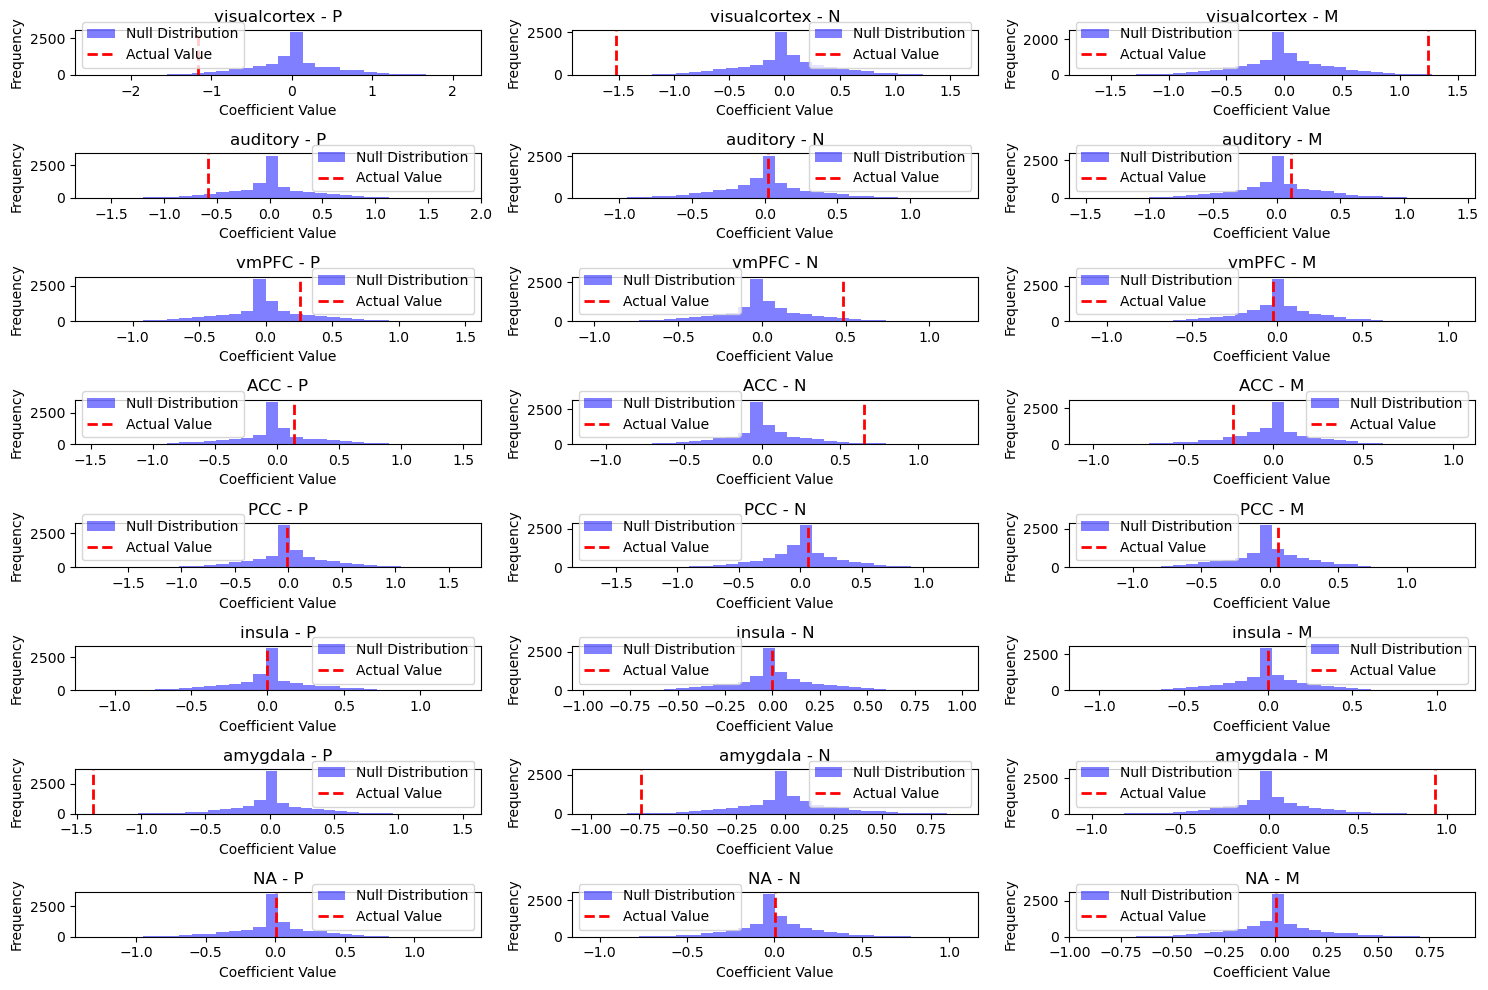

In [18]:
print('plotting true vs null dist')
plt.figure(figsize=(15, 10))
for r, roi in tqdm(enumerate(roi_selected), total=len(roi_selected)):
    for e, emo in enumerate(emotions):
        plt.subplot(len(roi_selected), len(emotions), r * len(emotions) + e + 1)
        plt.hist(perm_coefs[r, :, e], bins=30, color='blue', alpha=0.5, label='Null Distribution')
        plt.axvline(true_coefs[r, e], color='red', linestyle='dashed', linewidth=2, label='Actual Value')
        plt.title(f"{roi} - {emo}")
        plt.xlabel('Coefficient Value')
        plt.ylabel('Frequency')
        plt.legend()

plt.tight_layout()
# plt.savefig(f'{figure_path}/true_vs_null')

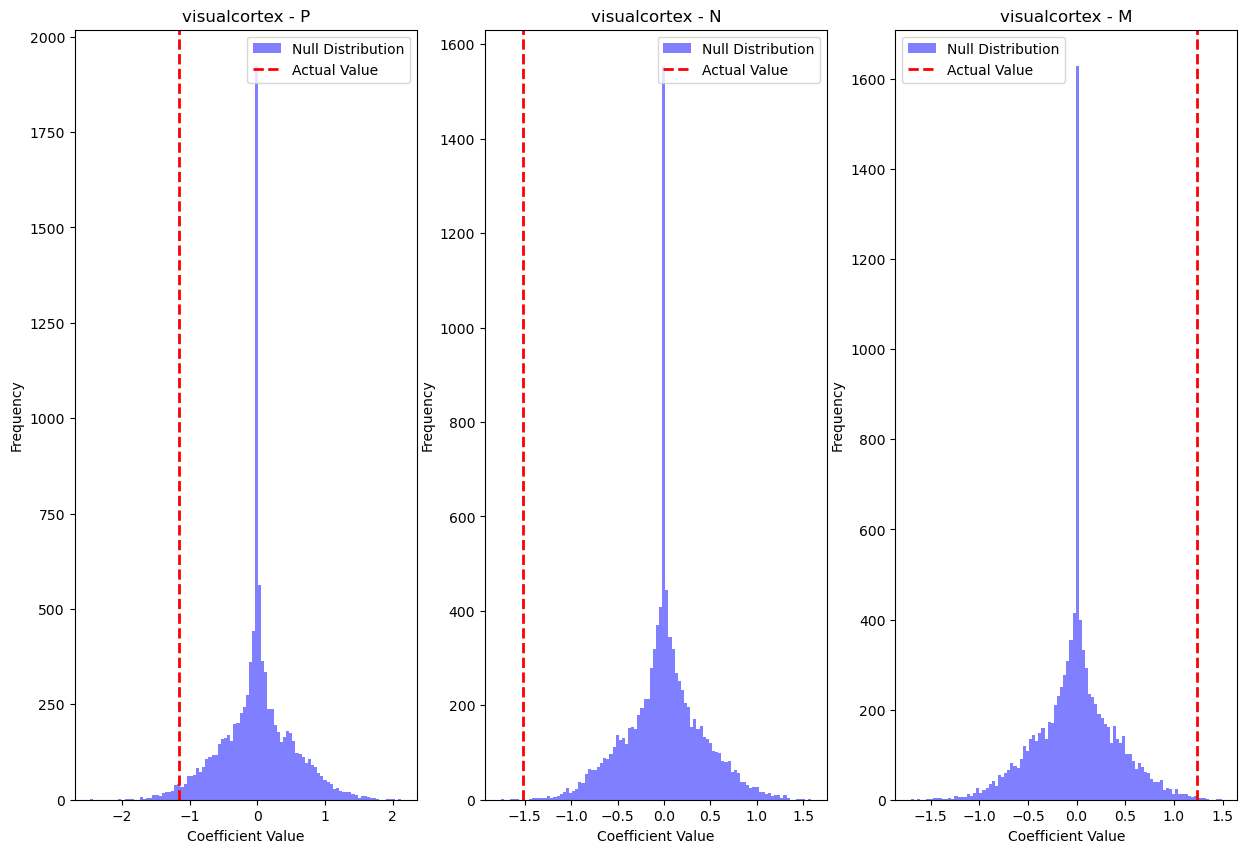

In [19]:
plt.figure(figsize=(15, 10))
for e, emo in enumerate(emotions):
    plt.subplot(1, len(emotions), e + 1)
    plt.hist(perm_coefs[0, :, e], bins=100, color='blue', alpha=0.5, label='Null Distribution')
    plt.axvline(true_coefs[0, e], color='red', linestyle='dashed', linewidth=2, label='Actual Value')
    plt.title(f"visualcortex - {emo}")
    plt.xlabel('Coefficient Value')
    plt.ylabel('Frequency')
    plt.legend()
plt.show()
# plt.savefig(f'{figure_path}/PCC_corr')


In [20]:
x[roi][2].shape

(10000, 85, 1)

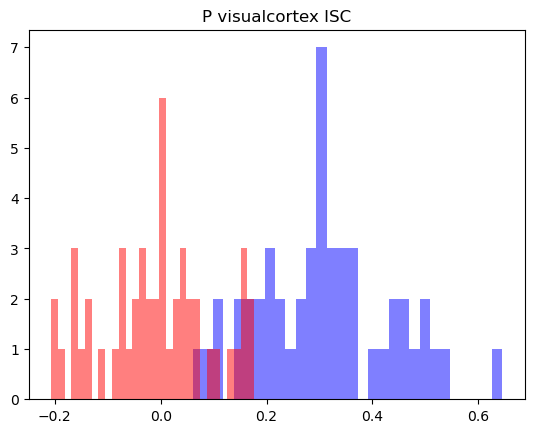

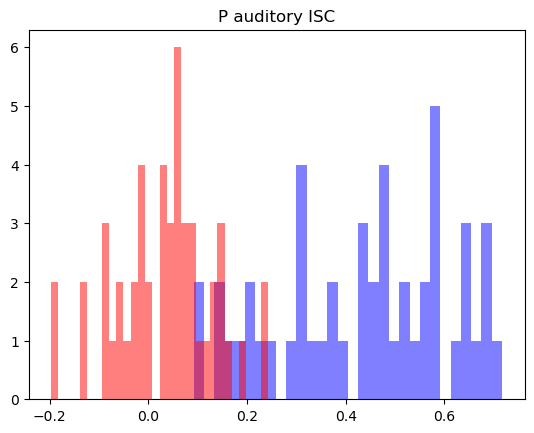

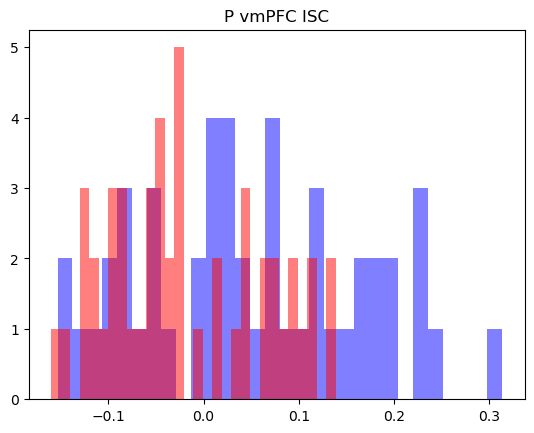

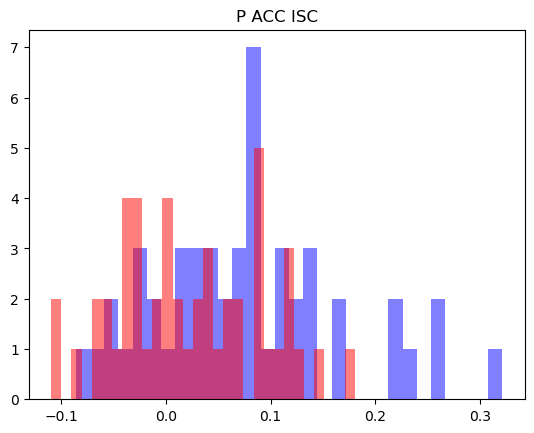

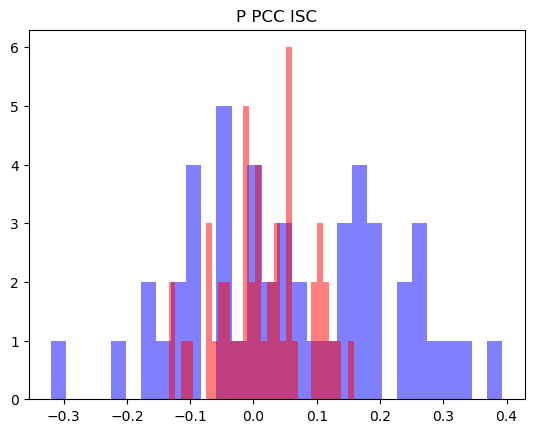

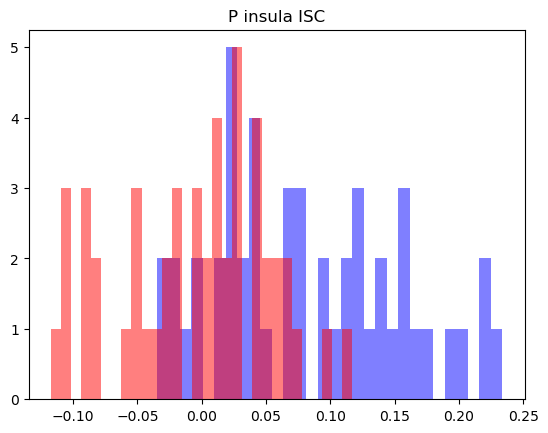

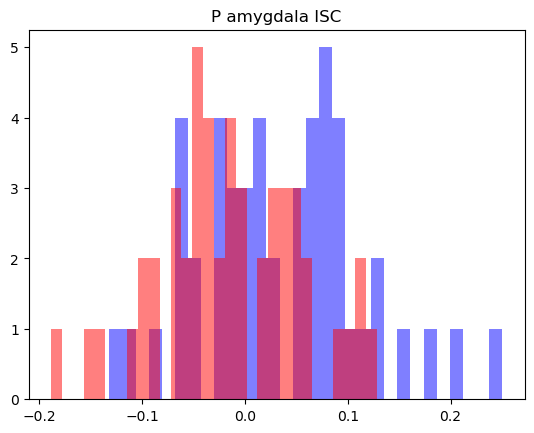

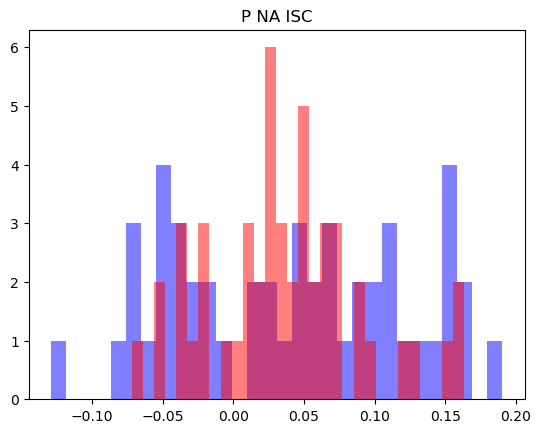

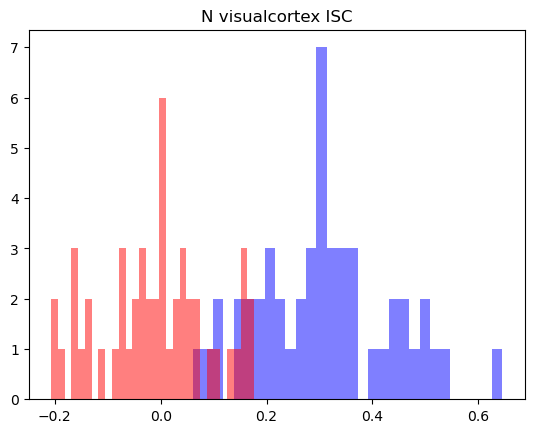

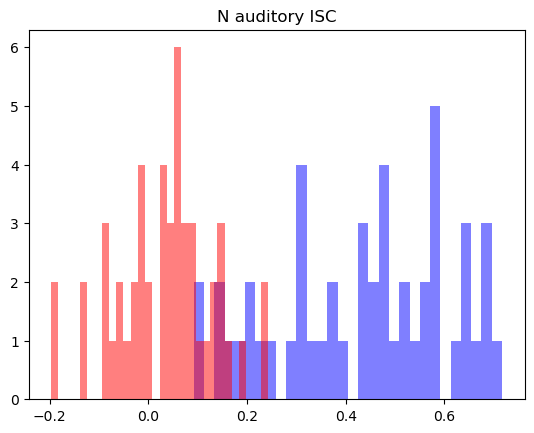

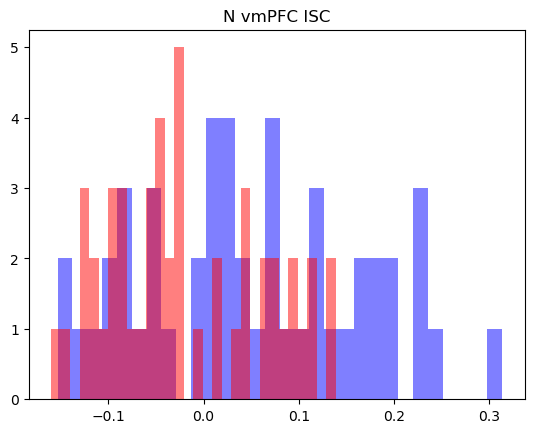

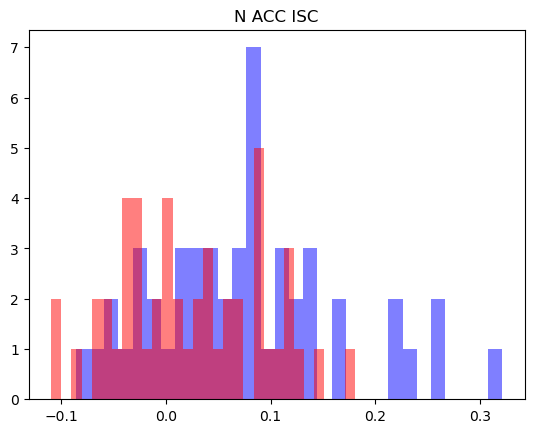

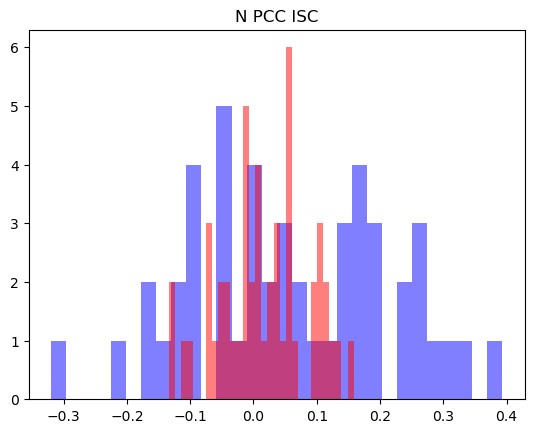

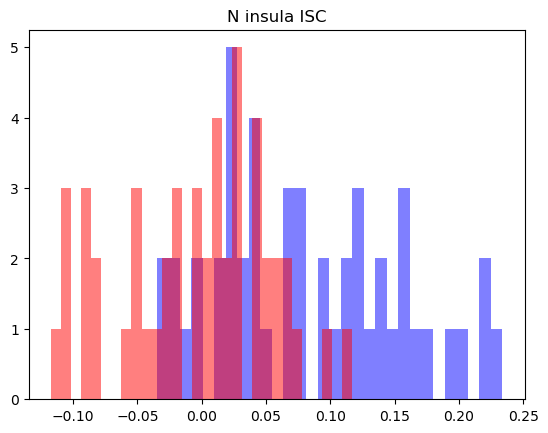

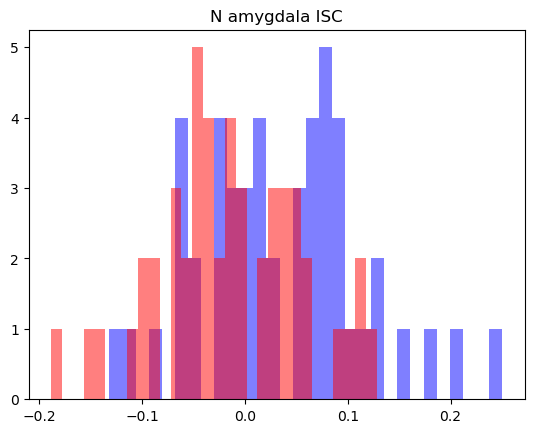

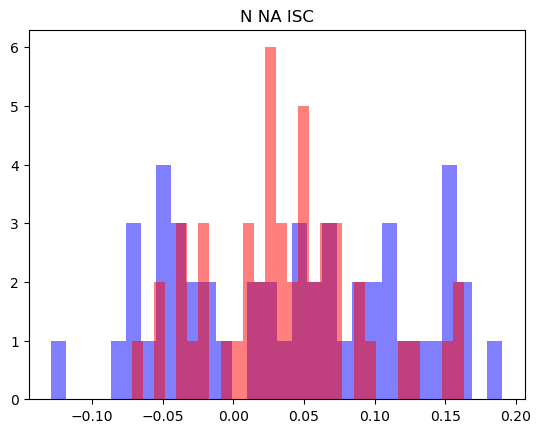

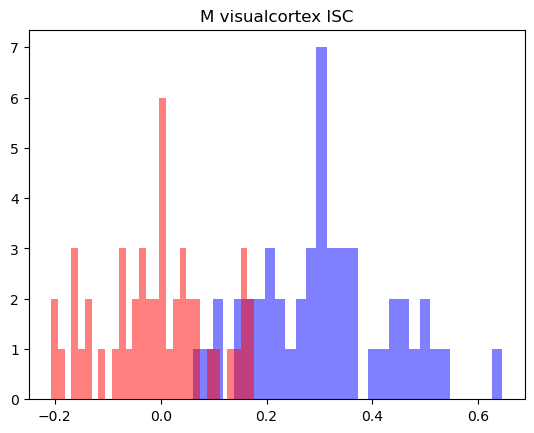

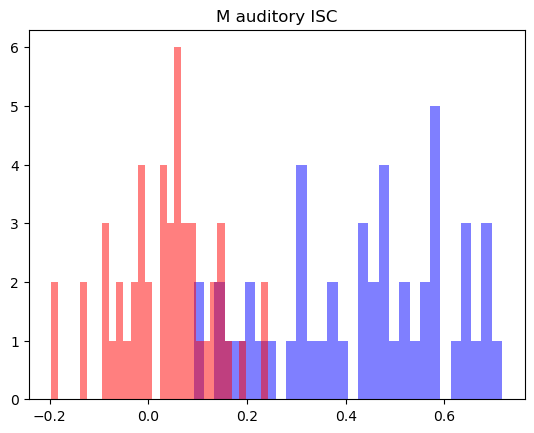

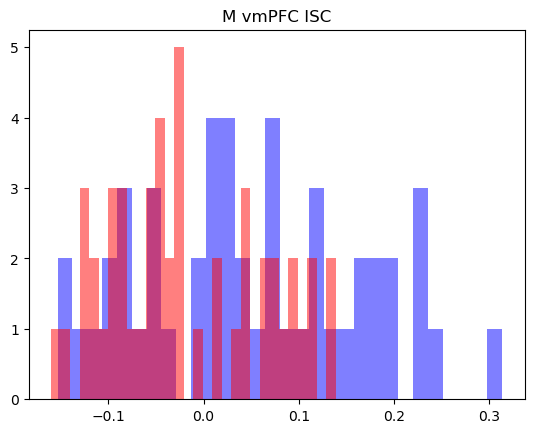

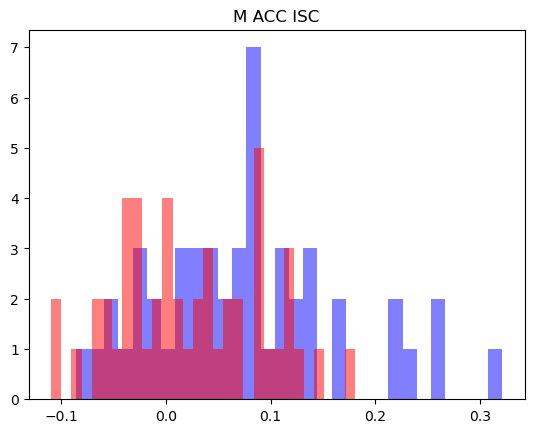

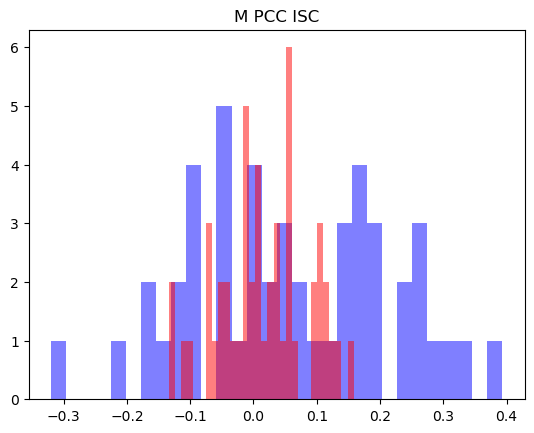

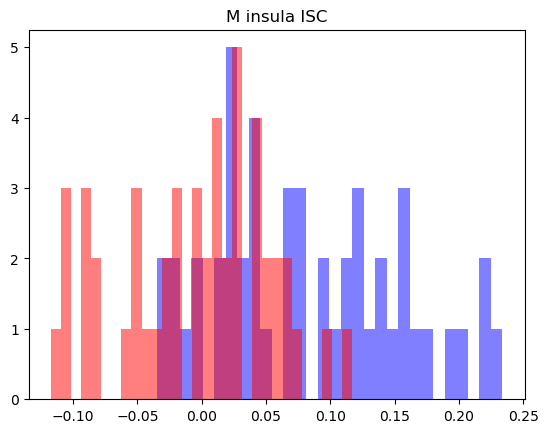

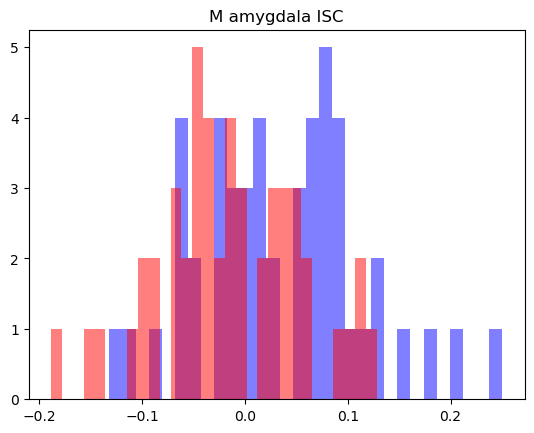

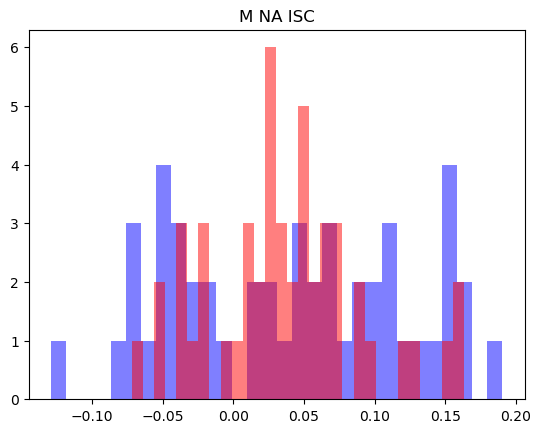

In [31]:
plt.figure()
for i, e in enumerate(emotions):
    for r, roi in enumerate(roi_selected):
        plt.hist(x[roi][0].flatten(), bins=30, color='blue', alpha=0.5)
        plt.hist(x[roi][2][0], bins=30, color='red', alpha=0.5)
        plt.title(f"{e} {roi} ISC")
        plt.show()
